<a href="https://colab.research.google.com/github/Denis-Yen/DataScience/blob/main/8_Sistemas_de_recomendcion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas de recomendación

### Carga de datos de movie lens

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Machine en Python  Udemy/Data/u.data.csv", sep="\t", header=None)
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
df.shape

(100000, 4)

In [ ]:
df.columns = ["UserID", "ItemID", "Rating", "TimeStamp"]
df.head()

## Análisis exploratorio de datos

In [ ]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

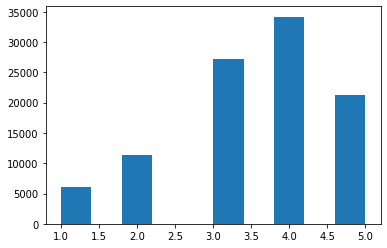

In [ ]:
plt.hist(df.Rating)

(array([11459.,  5724., 19359.,  9315.,  9396., 10083.,  6175.,  9603.,
        10048.,  8838.]),
 array([8.74724710e+08, 8.76580903e+08, 8.78437096e+08, 8.80293288e+08,
        8.82149481e+08, 8.84005674e+08, 8.85861867e+08, 8.87718060e+08,
        8.89574252e+08, 8.91430445e+08, 8.93286638e+08]),
 <a list of 10 Patch objects>)

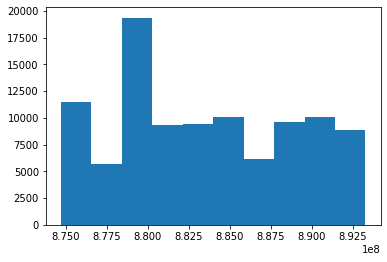

In [ ]:
plt.hist(df.TimeStamp)

In [ ]:
df.groupby(["Rating"])["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

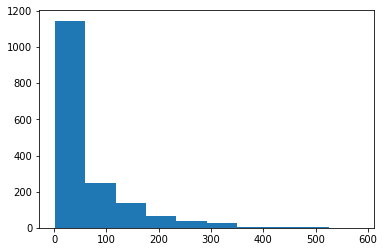

In [ ]:
plt.hist(df.groupby("ItemID")["ItemID"].count())

## Representación en forma matricial

Realizamos la conversión a una matriz para cruzar los usuarios con las peliculas y la intersección sera la valoración


In [ ]:
import numpy as np

In [ ]:
n_users = df.UserID.unique().shape[0]
n_users 

943

In [ ]:
n_items = df.ItemID.unique().shape[0]
n_items

1682

In [ ]:
 np.zeros((5,4), dtype=float) # matriz de ceros de 5*5, de tipo float
ratings = np.zeros((n_users, n_items))
ratings.shape # Matriz de ceros de 943 filas con 1682 columnas

(943, 1682)

In [ ]:
for row in df.itertuples():
  ratings[row[1]-1, row[2]-1] = row[3]

In [ ]:
type(ratings)

numpy.ndarray

In [ ]:
ratings.shape

(943, 1682)

In [ ]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

Se puede calcular el coeficiente de sparseidad, que porcentahe de la matriz no tiene ceros

In [ ]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity/= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("coeficiente de sparsiedad: {:2.3f}%".format(sparsity))

coeficiente de sparsiedad: 6.305%


## Crear conjuntos de entrenamiento y validación¶


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
ratings_train, ratings_test =  train_test_split(ratings, test_size = 0.3, random_state = 42)

In [ ]:
ratings_train.shape,ratings_test.shape

((660, 1682), (283, 1682))

## Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre los usuarios (distancia del coseno).
* Predecir la valoración desconocida de un ítem i para un usuario activo u basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [ ]:
import numpy as np
import sklearn

In [ ]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [ ]:
type(sim_matrix)

numpy.ndarray

In [ ]:
sim_matrix.shape # 660 usuarios contra si mismos

(660, 660)

In [ ]:
sim_matrix # cada usuario esta a 1 de distancia de si mismo

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [ ]:
### Prediciendo las valoraciones
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis = 1)]).T  # ponderación por todos los usuariuos d ela misma fila


In [ ]:
users_predictions

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [ ]:
# comprobar el error cuadratico medio
from sklearn.metrics import mean_squared_error

In [ ]:
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [ ]:
get_mse(users_predictions, ratings_train)

7.878218313143215

In [ ]:
get_mse(users_predictions, ratings_test)

## Filtro colaborativo basado en los KNN


In [ ]:
from sklearn.neighbors import NearestNeighbors


In [ ]:
k = 5
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius='cosine')

In [ ]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)


In [ ]:
top_k_distances.shape, top_k_distances[0], top_k_users.shape, top_k_users[0]


((660, 5),
 array([ 0.        , 41.71330723, 43.3474336 , 45.04442252, 45.04442252]),
 (660, 5),
 array([  0, 211,  16, 583, 428]))

In [ ]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [ ]:
users_predicts_k.shape


(660, 1682)

In [ ]:
users_predicts_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74469557, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.9753676 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
get_mse(users_predicts_k, ratings_train)

8.180803170774984

In [ ]:
get_mse(users_predicts_k, ratings_test.T)

13.529678551329162

## Filtro colaborativo basado en Items


In [ ]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [ ]:
neighbors = NearestNeighbors(n_movies, 'cosine')

In [ ]:
neighbors.fit(ratings_train.T) # usamoa la transpuesta por que estan en las columnas

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=1682, p=2,
                 radius='cosine')

In [ ]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [ ]:
top_k_distances.shape

In [ ]:
top_k_distances

array([[ 0.        , 53.12249994, 54.38749856, ..., 77.08436936,
        77.39509028, 79.3473377 ],
       [ 0.        , 27.        , 27.29468813, ..., 72.18032973,
        75.65712128, 80.0874522 ],
       [ 0.        , 24.77902339, 25.05992817, ..., 72.09022125,
        75.27283707, 83.11437902],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 77.12976079,
        80.79603951, 88.63407922],
       [ 0.        ,  1.        ,  3.        , ..., 76.99350622,
        80.7403245 , 88.51553536],
       [ 0.        ,  1.        ,  3.        , ..., 77.03246069,
        80.66597796, 88.51553536]])

In [ ]:
top_k_items.shape

(1682, 1682)

In [ ]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1565, 1571, 1570, ...,  180,   99,   49],
       [1680, 1671, 1582, ...,  180,   99,   49],
       [1681, 1596, 1592, ...,  180,   99,   49]])

In [ ]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [ ]:
item_preds.shape

(660, 1682)

In [ ]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1565, 1571, 1570, ...,  180,   99,   49],
       [1680, 1671, 1582, ...,  180,   99,   49],
       [1681, 1596, 1592, ...,  180,   99,   49]])

In [ ]:
get_mse(item_preds, ratings_train)

11.172565375125632

In [ ]:
item_preds = ratings_test.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [ ]:
get_mse(item_preds, ratings_test)

10.937029821811949

## Filtrado colaborativo basado en KNN


In [ ]:
k = 30
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [ ]:
top_k_distances.shape

(1682, 30)

In [ ]:
top_k_items[0]

array([  0, 120, 404, 116, 221, 150, 117, 180,   6, 741,  27,  94, 256,
       236, 124,  81,  24, 587, 227, 110, 234,  78, 203, 545,  70,  14,
        68, 596,  49, 143])

In [ ]:
top_k_distances[0]

array([ 0.        , 53.12249994, 54.38749856, 55.50675635, 56.49778757,
       56.9473441 , 57.21013896, 57.81003373, 58.10335619, 58.16356248,
       58.19793811, 58.37807808, 58.70264049, 58.83876273, 58.97457079,
       59.52310476, 59.61543424, 59.84981203, 59.89156869, 59.94163828,
       60.15812497, 60.35726965, 60.37383539, 60.63002556, 60.86049622,
       61.11464636, 61.31883887, 61.37589103, 61.57109712, 61.80614856])

In [ ]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    if(i%50==0):
        print("iter "+str(i))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis=0)>0):
        den = np.abs(top_k_distances[i]).sum(axis=0)
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([den]).T

iter 0
iter 50
iter 100
iter 150
iter 200
iter 250
iter 300
iter 350
iter 400
iter 450
iter 500
iter 550
iter 600
iter 650
iter 700
iter 750
iter 800
iter 850
iter 900
iter 950
iter 1000
iter 1050
iter 1100
iter 1150
iter 1200
iter 1250
iter 1300
iter 1350
iter 1400
iter 1450
iter 1500
iter 1550
iter 1600
iter 1650


In [ ]:
get_mse(preds, ratings_train)

8.732017359673444

In [ ]:
get_mse(preds, ratings_test)

11.569842429886506

In [ ]:
preds.shape

(1682, 660)

In [ ]:
ratings_train.shape

(660, 1682)

In [ ]:
ratings_test.shape 

(283, 1682)